Loading dataset...
Computing persistence diagrams...
Computed persistence diagrams with shape: (2000, 11034, 3)
Extracting TDA features...
pi_features original shape: (2000, 2, 20, 20)
pi_features reshaped to 2D: (2000, 800)
pl_features shape: (2000, 10, 50)
pl_features reshaped to 2D: (2000, 500)
Extracted TDA features with shape: (2000, 1300)
Applying SMOTE to balance classes...
Training and evaluating classifier on balanced data...
CV Accuracy: 0.9487 ± 0.0052
Model saved to tda_skin_cancer_model.joblib
Test set accuracy: 0.9578441835645678
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       267
           1       0.95      0.99      0.97       267
           2       0.94      0.93      0.93       268
           3       0.97      1.00      0.99       268
           4       0.96      0.81      0.88       268
           5       0.91      0.99      0.95       268
           6       0.99      1.00      1.00    

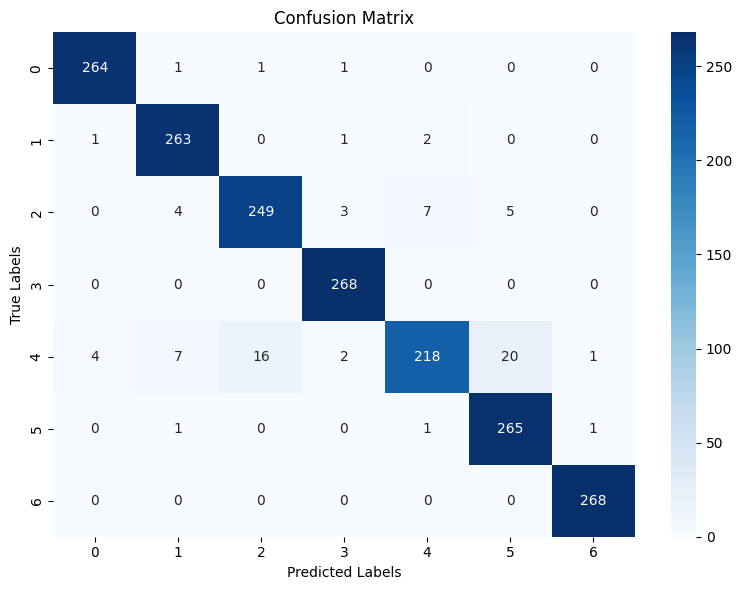

In [1]:
import numpy as np
from gtda.homology import CubicalPersistence
from gtda.diagrams import PersistenceImage, PersistenceLandscape
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")


def load_data(image_path, label_path, sample_size=None):
    X = np.load(image_path)  # shape (N, H, W) or (N, H, W, C)
    y = np.load(label_path)  # shape (N,)
    if X.ndim == 4:
        X = 0.2989 * X[..., 0] + 0.5870 * X[..., 1] + 0.1140 * X[..., 2]

    if sample_size is not None:
        X = X[:sample_size]
        y = y[:sample_size]
    return X, y

def compute_persistence_diagrams(X):
    cubical_persistence = CubicalPersistence(homology_dimensions=[0,1], n_jobs=-1)
    diagrams = cubical_persistence.fit_transform(X)
    return diagrams

def extract_tda_features(diagrams):
    pi = PersistenceImage(
        sigma=1.0,
        n_bins=20,
        weight_function=lambda x: x[1] ** 2
    )
    pi_features = pi.fit_transform(diagrams)
    print("pi_features original shape:", pi_features.shape)

    pi_features = pi_features.reshape((pi_features.shape[0], -1))
    print("pi_features reshaped to 2D:", pi_features.shape)

    pl = PersistenceLandscape(n_layers=5, n_bins=50)
    pl_features = pl.fit_transform(diagrams)
    print("pl_features shape:", pl_features.shape)

    pl_features = pl_features.reshape((pl_features.shape[0], -1))
    print("pl_features reshaped to 2D:", pl_features.shape)

    combined_features = np.hstack((pi_features, pl_features))
    return combined_features


def train_evaluate(X_features, y, save_path="tda_skin_cancer_model.joblib"):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y, test_size=0.2, random_state=42, stratify=y)

    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

    clf.fit(X_train, y_train)
    joblib.dump(clf, save_path)
    print(f"Model saved to {save_path}")

    y_pred = clf.predict(X_test)
    print("Test set accuracy:", accuracy_score(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    labels = sorted(np.unique(y_test))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    train_images_path = "/home/sajedhamdan/Desktop/skin_cancer/images_train_256x192.npy"
    train_labels_path = "/home/sajedhamdan/Desktop/skin_cancer/train_labels.npy"
    model_save_path = "tda_skin_cancer_model.joblib"

    print("Loading dataset...")
    X, y = load_data(train_images_path, train_labels_path)

    X_sampled, _, y_sampled, _ = train_test_split(
        X, y, train_size=2000, stratify=y, random_state=42
    )

    print("Computing persistence diagrams...")
    diagrams = compute_persistence_diagrams(X_sampled)
    print(f"Computed persistence diagrams with shape: {diagrams.shape}")

    print("Extracting TDA features...")
    features = extract_tda_features(diagrams)
    print(f"Extracted TDA features with shape: {features.shape}")

    print("Applying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    features_balanced, y_balanced = smote.fit_resample(features, y_sampled)

    print("Training and evaluating classifier on balanced data...")
    train_evaluate(features_balanced, y_balanced, save_path=model_save_path)
